In [138]:
%matplotlib inline
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
import pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf, q_stat
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.graphics.gofplots import qqplot

In [18]:
data = pd.read_csv('../data/siteA.csv')

In [20]:
data['Date_Name'] = data['Date_Name'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [21]:
print data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66160 entries, 0 to 66159
Data columns (total 4 columns):
Date_Name        66160 non-null datetime64[ns]
subCategory      66160 non-null object
Purchase_Hour    66160 non-null int64
sales            66160 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.0+ MB
None


In [22]:
# Make a dataframe for each category, and put it into a list...len(list) = 16
# Essentially becomes a list of dataframe
def make_dataframe(df, lis):
    f = lambda x: df[df['subCategory'] == x]
    return map(f, lis)

temp_list = data['subCategory'].unique()
splitted_data = make_dataframe(data, temp_list)
print len(splitted_data)
print splitted_data[2][0:5]

16
      Date_Name subCategory  Purchase_Hour   sales
9259 2016-03-01           C              7  460.34
9260 2016-03-04           C              7  414.03
9261 2016-03-07           C              7  370.37
9262 2016-03-08           C              7  368.68
9263 2016-03-11           C              7  439.15


In [255]:
# Looks like some have missing dates, like category #10 has only half of the data.
for i in range(0,16):
    temp_A = splitted_data[i].groupby(by=['Date_Name'])['sales'].sum()
    print i, ':', temp_A.shape

temp_A = splitted_data[i].groupby(by=['Date_Name'])['sales'].sum()

0 : (345,)
1 : (345,)
2 : (345,)
3 : (319,)
4 : (339,)
5 : (345,)
6 : (345,)
7 : (345,)
8 : (330,)
9 : (343,)
10 : (194,)
11 : (345,)
12 : (345,)
13 : (346,)
14 : (300,)
15 : (328,)


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


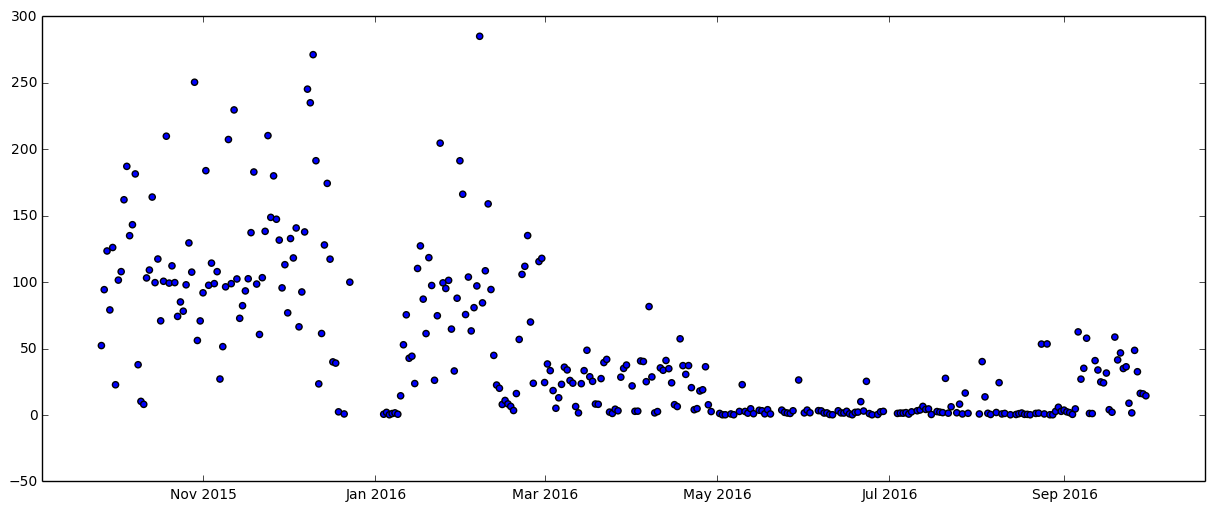

In [26]:
# Time series in scattered plot format...
plt.scatter(temp_A.index, temp_A)

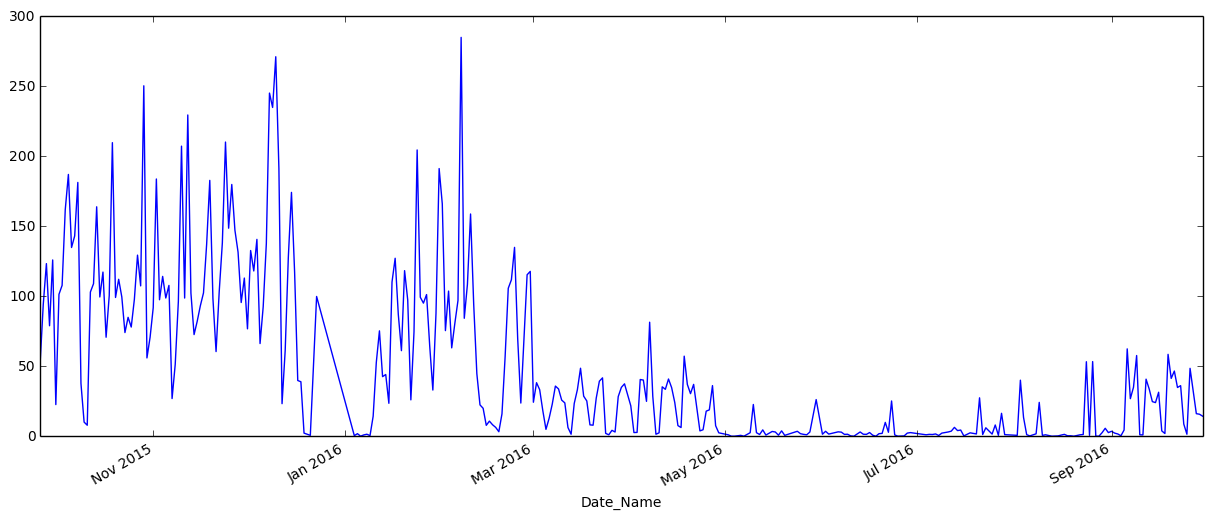

In [24]:
temp_A.plot()

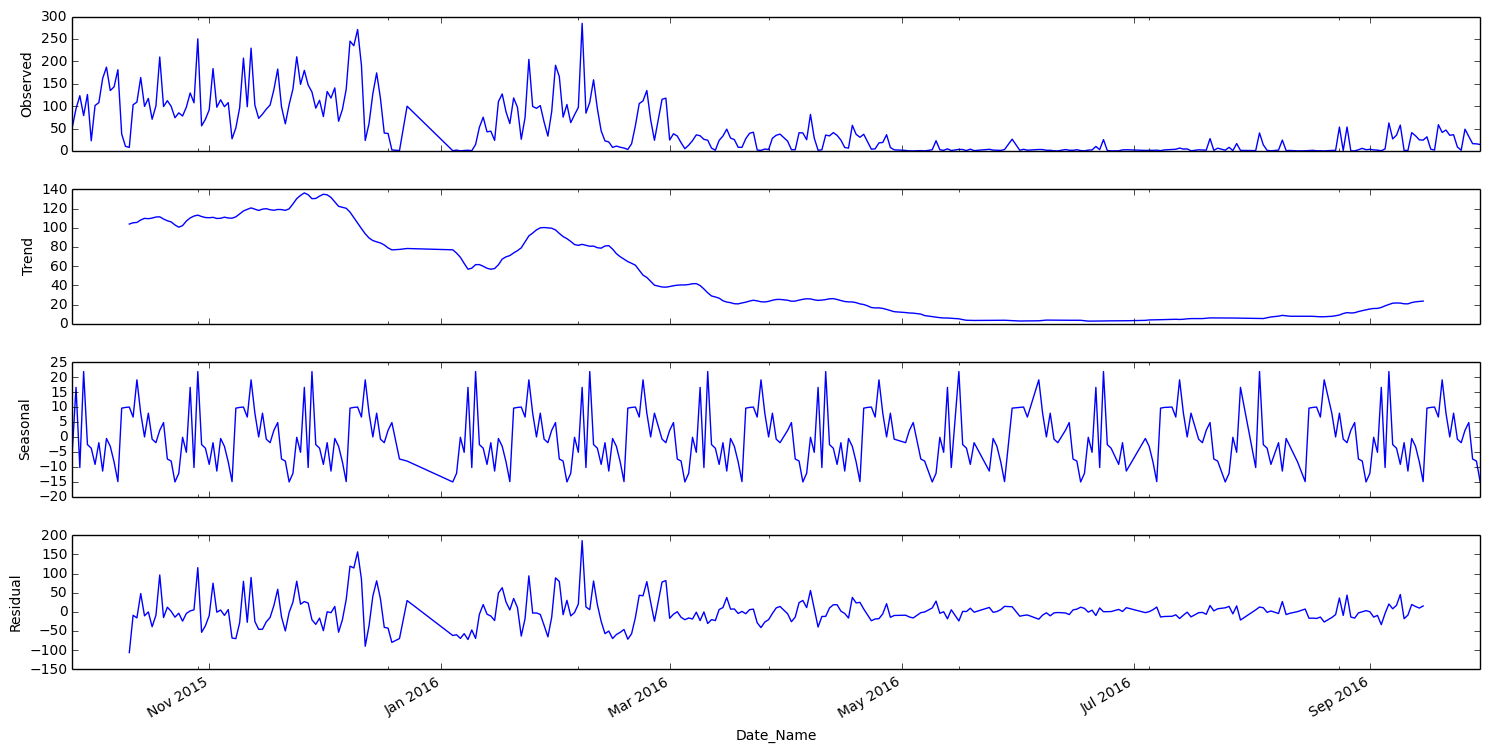

In [75]:
# Category A, seasonal decomposition plots...
decomposition = seasonal_decompose(temp_A, freq=30)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [27]:
# A function to test serie's stationarity... 
def test_stationarity(timeseries, category):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('{} - Rolling Mean & Standard Deviation'.format(category))
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


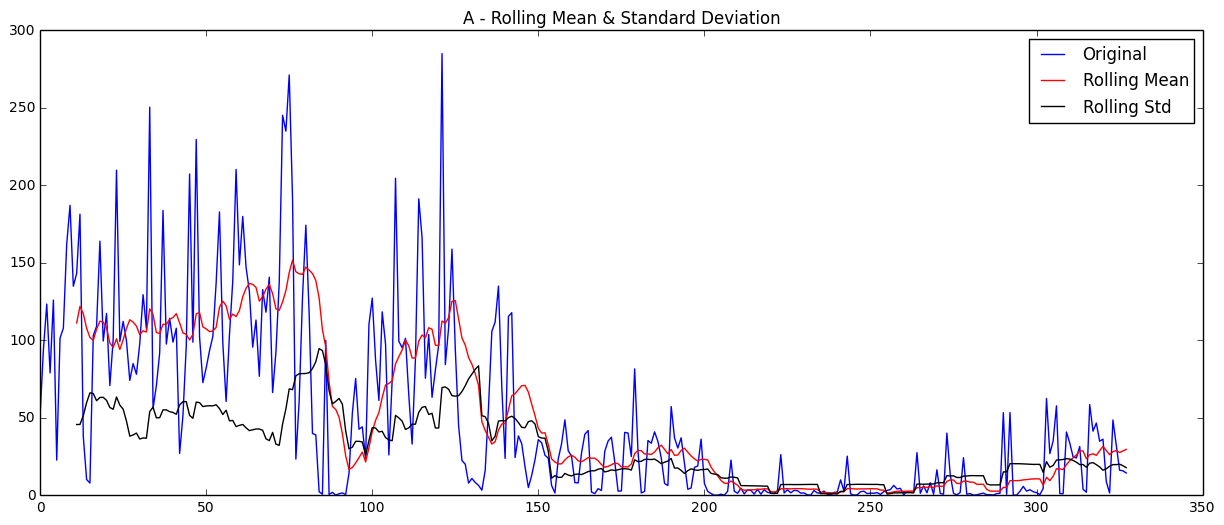

Results of Dickey-Fuller Test:
Test Statistic                  -1.894930
p-value                          0.334450
#Lags Used                      17.000000
Number of Observations Used    310.000000
Critical Value (5%)             -2.870909
Critical Value (1%)             -3.451622
Critical Value (10%)            -2.571762
dtype: float64


In [28]:
test_stationarity(temp_A, 'A')

### Category 'A' is not stationary...let's make it stationary!

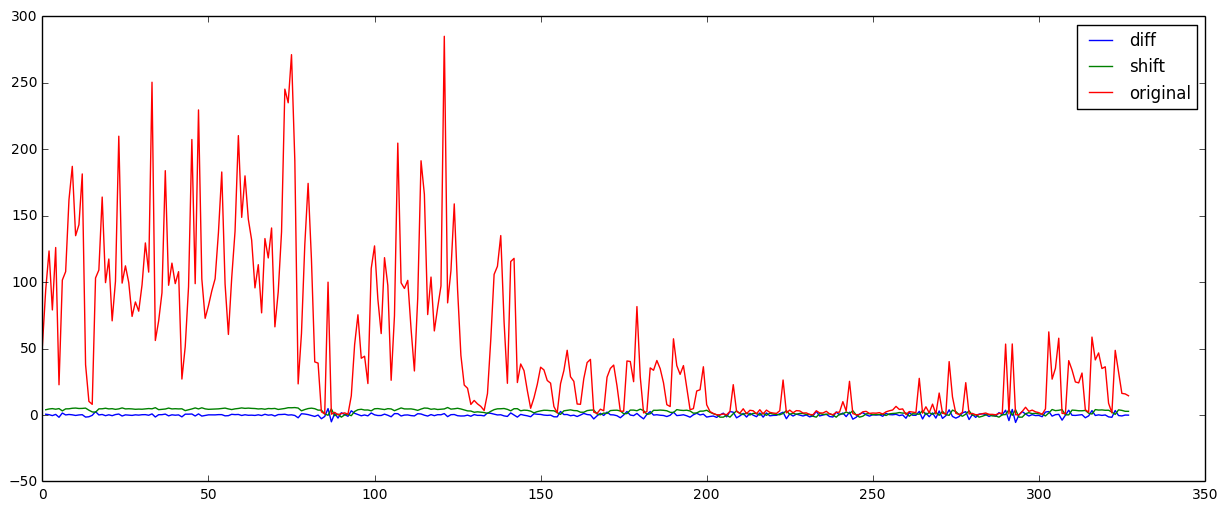

In [271]:
# Differencing to deal with trend...
temp_A_diff = np.log(temp_A) - np.log(temp_A).shift()
plt.plot(temp_A_diff, label='diff')
plt.plot(np.log(temp_A).shift(), label='shift')
plt.plot(temp_A, label='original')
plt.legend(loc='best')

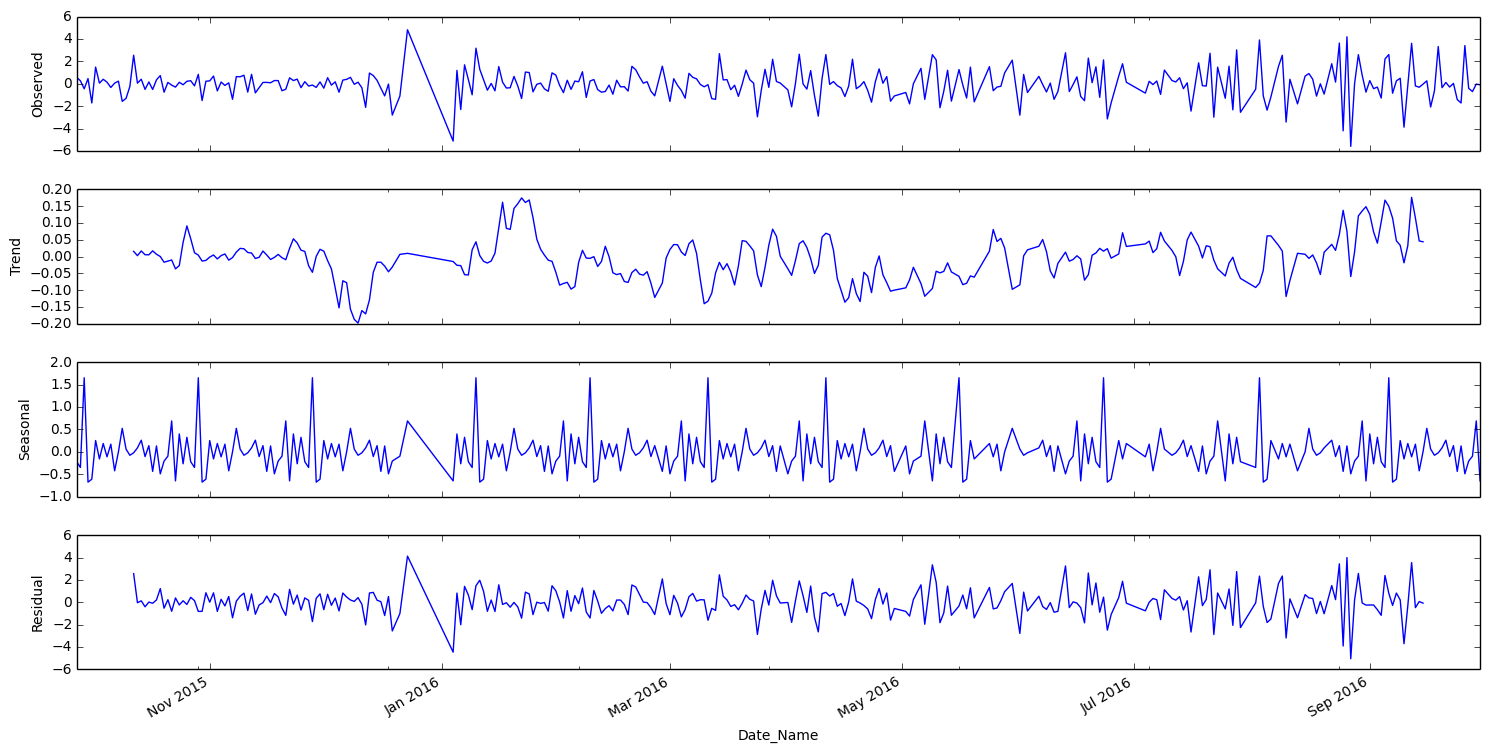

In [272]:
temp_A_diff.dropna(inplace=True)
# Category A, seasonal decomposition plots...
decomposition_diff = seasonal_decompose(temp_A_diff, freq=30)
fig = plt.figure()
fig = decomposition_diff.plot()
fig.set_size_inches(15, 8)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/Library/Python/2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


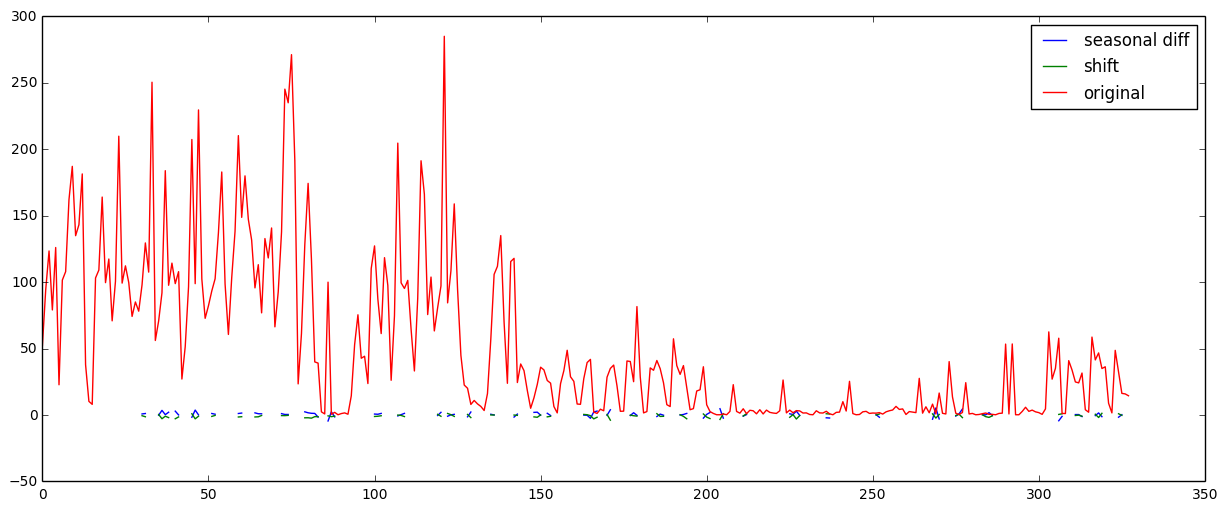

In [277]:
# Differencing to deal with seasonality...
temp_A_season = temp_A_diff - np.log(temp_A_diff).shift(30)
plt.plot(temp_A_season, label='seasonal diff')
plt.plot(np.log(temp_A_diff).shift(30), label='shift')
plt.plot(temp_A, label='original')
plt.legend(loc='best')

In [283]:
temp_A_season.dropna(inplace=True)
temp_A_season.isnull().values.sum()

0

In [281]:
temp_A_season.dropna(inplace=True)
# Category A, seasonal decomposition plots...
decomposition_season = seasonal_decompose(temp_A_season, freq=30)
fig = plt.figure()
fig = decomposition_season.plot()
fig.set_size_inches(15, 8)

ValueError: This function does not handle missing values

0
0


/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


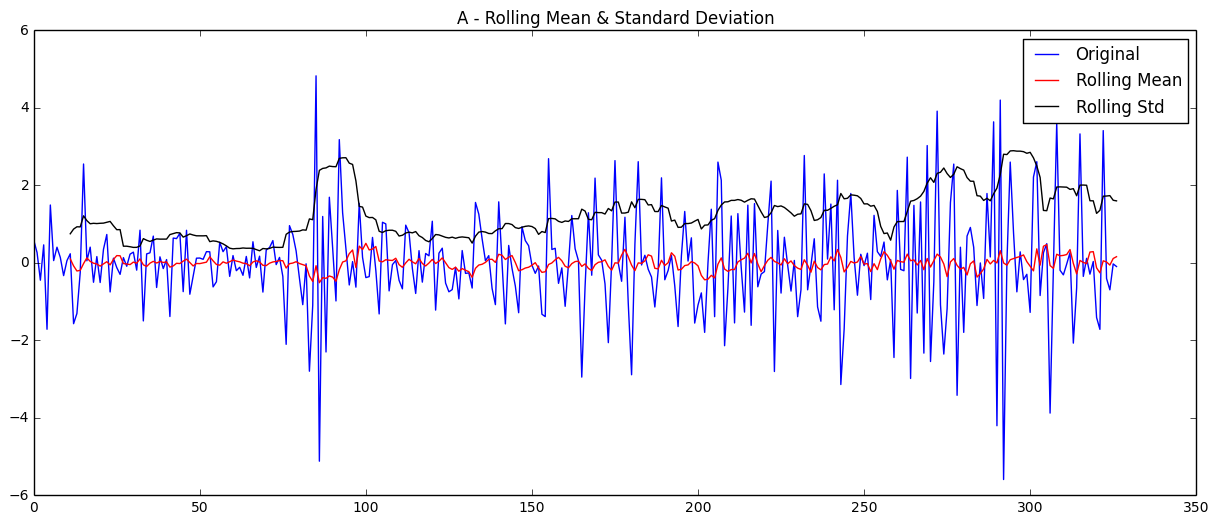

Results of Dickey-Fuller Test:
Test Statistic                -8.402784e+00
p-value                        2.208275e-13
#Lags Used                     1.200000e+01
Number of Observations Used    3.140000e+02
Critical Value (5%)           -2.870789e+00
Critical Value (1%)           -3.451349e+00
Critical Value (10%)          -2.571698e+00
dtype: float64


In [284]:
# Let's see the Dickey-Fuller test after taking the diff...
print temp_A_diff.isnull().values.sum()
temp_A_diff.dropna(inplace=True)
print temp_A_diff.isnull().values.sum()
test_stationarity(temp_A_diff, 'A')

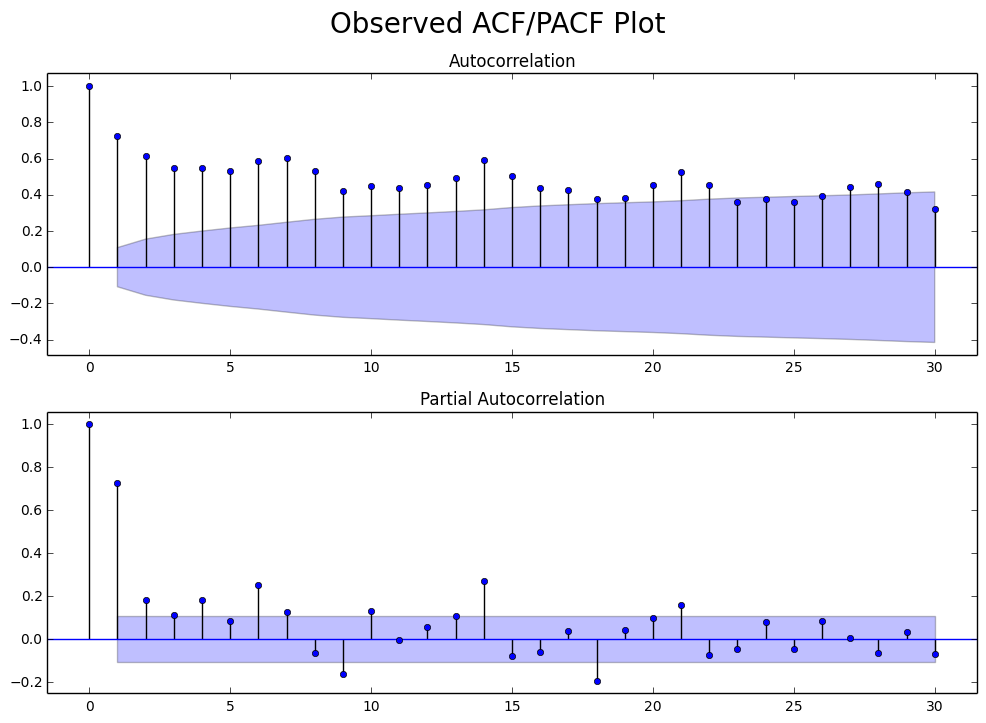

In [285]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A, lags=30, ax=ax2)
fig.suptitle('Observed ACF/PACF Plot', fontsize=20)

### PACF cuts off at 1, probably AR(1) model...

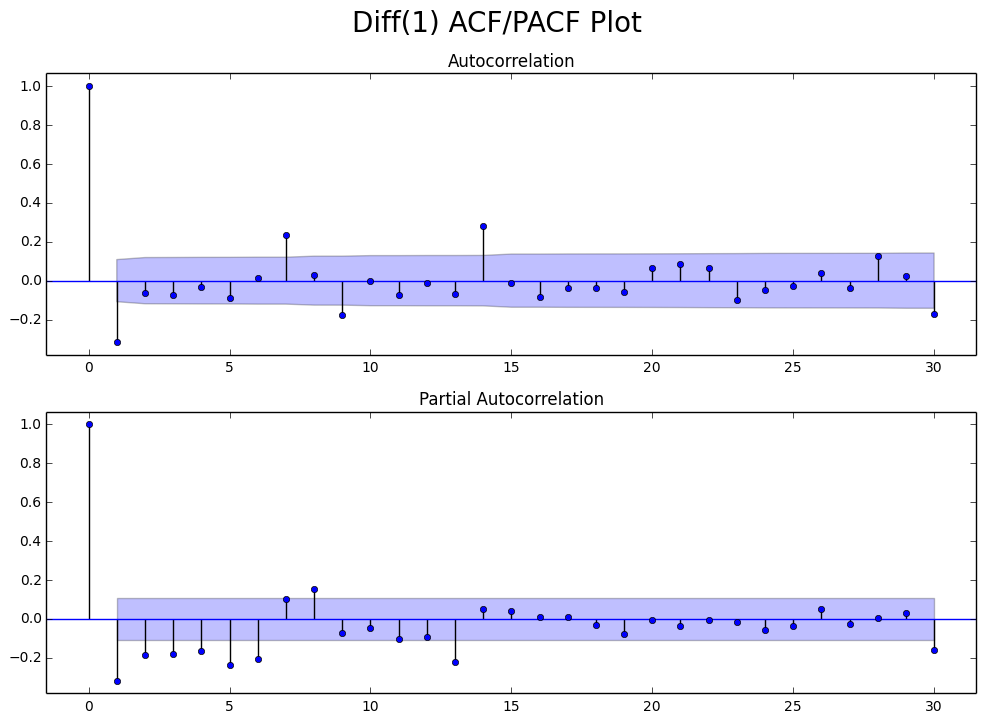

In [286]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A_diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A_diff, lags=30, ax=ax2)
fig.suptitle('Diff(1) ACF/PACF Plot', fontsize=20)

### Difference has both tails off, thus, ARMA behavior.
### So...the observed data may be ARIMA...

/Library/Python/2.7/site-packages/statsmodels/tsa/stattools.py:353: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.mean()


ValueError: operands could not be broadcast together with shapes (182,) (151,) (182,) 

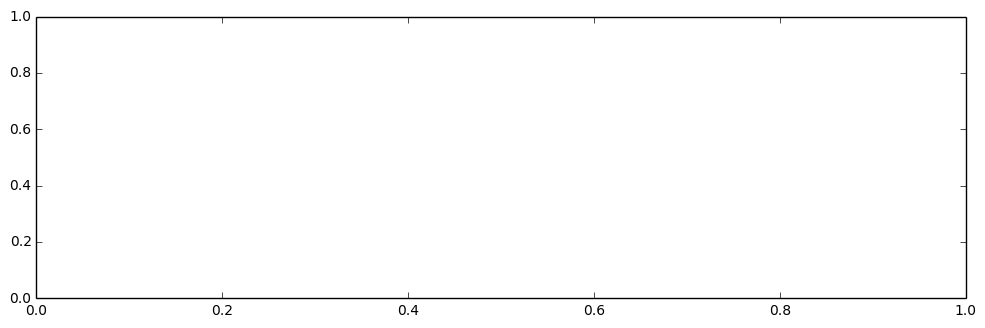

In [287]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_A_season, lags=183, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_A_season, lags=183, ax=ax2)
fig.suptitle('Diff(30) ACF/PACF Plot', fontsize=20)

### Seasonal both tails off...SARIMA(1, 1, 1)?

In [288]:
mod = sm.tsa.statespace.SARIMAX(np.log(temp_A), trend='n', order=(1,1,0), seasonal_order=(1,1,1,30))
results_1 = mod.fit()
print results_1.summary()

                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                  328
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 30)   Log Likelihood                -526.546
Date:                            Wed, 15 Feb 2017   AIC                           1061.092
Time:                                    23:43:36   BIC                           1076.264
Sample:                                09-26-2015   HQIC                          1067.145
                                     - 09-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2947      0.043     -6.869      0.000      -0.379      -0.211
ar.S.L30      -0.2229      0.088   

In [289]:
# This seems to generate better AIC/BIC...
mod = sm.tsa.statespace.SARIMAX(np.log(temp_A), trend='n', order=(1,1,1), seasonal_order=(0,1,1,30))
results_2 = mod.fit()
print results_2.summary()

                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                  328
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 30)   Log Likelihood                -511.431
Date:                            Wed, 15 Feb 2017   AIC                           1030.862
Time:                                    23:43:51   BIC                           1046.034
Sample:                                09-26-2015   HQIC                          1036.915
                                     - 09-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3883      0.059      6.618      0.000       0.273       0.503
ma.L1         -0.8710      0.032   

In [290]:
# This seems to generate better AIC/BIC...
mod = sm.tsa.statespace.SARIMAX(np.log(temp_A), trend='n', order=(1,1,1), seasonal_order=(1,1,1,30))
results_3 = mod.fit()
print results_3.summary()

                                 Statespace Model Results                                 
Dep. Variable:                              sales   No. Observations:                  328
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood                -505.701
Date:                            Wed, 15 Feb 2017   AIC                           1021.402
Time:                                    23:44:27   BIC                           1040.367
Sample:                                09-26-2015   HQIC                          1028.968
                                     - 09-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4105      0.060      6.833      0.000       0.293       0.528
ma.L1         -0.8775      0.032   

In [291]:
residuals = pd.DataFrame(results_3.resid)
print residuals.head()
print residuals.describe()

                   0
Date_Name           
2015-09-26  3.956423
2015-09-27  0.590591
2015-09-28  0.268989
2015-09-29 -0.445411
2015-09-30  0.466330
                0
count  328.000000
mean     0.013416
std      1.280542
min     -4.552863
25%     -0.731015
50%      0.053166
75%      0.686041
max      4.344445


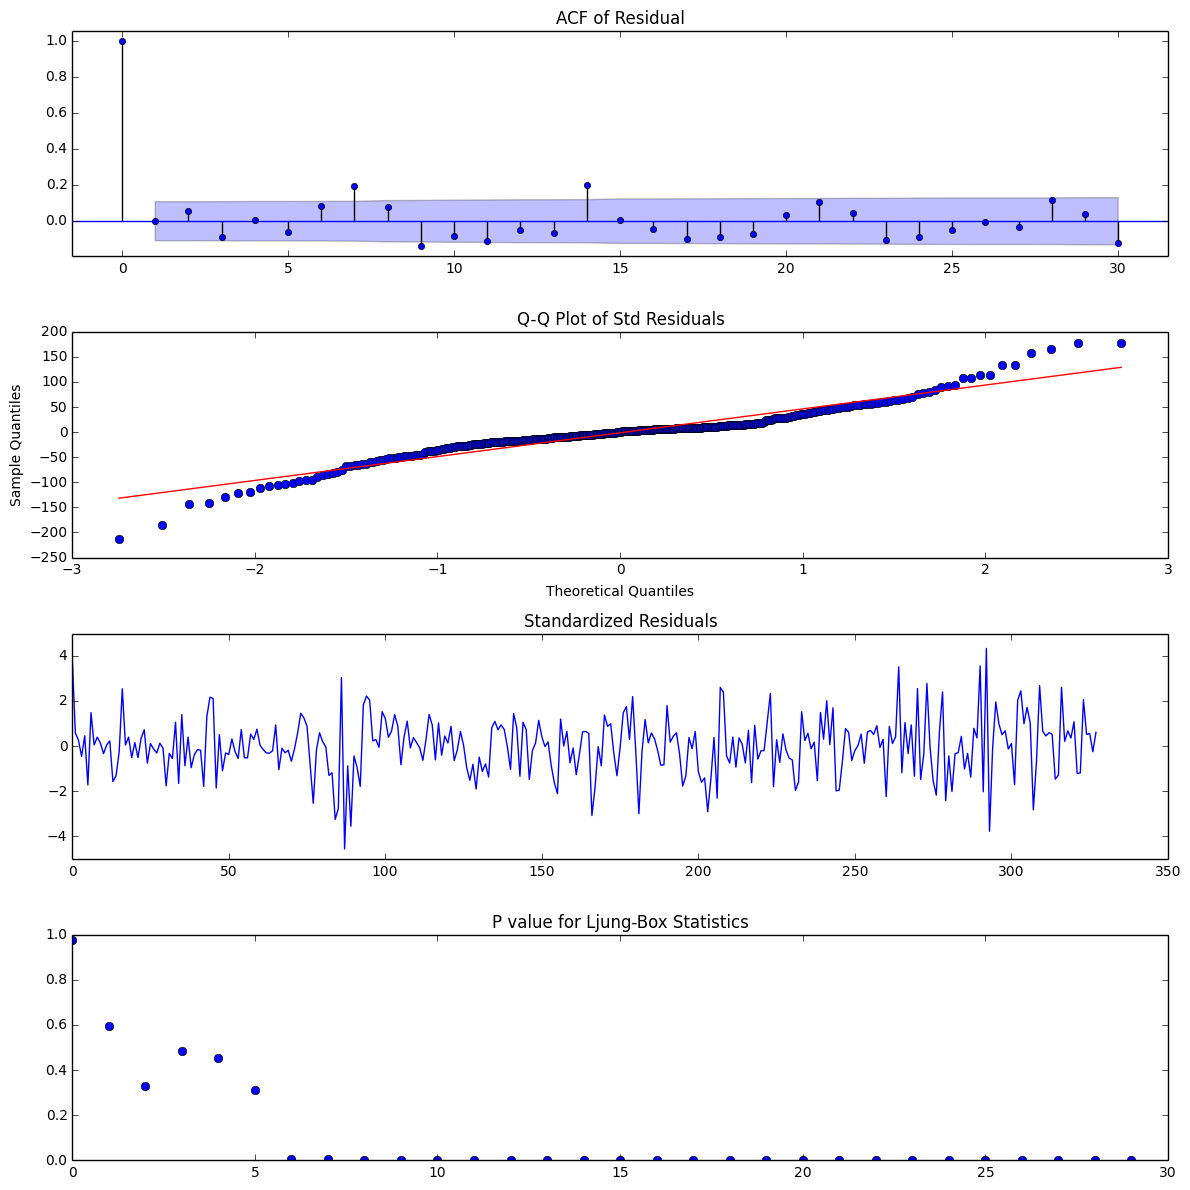

In [292]:
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(411)
ax1 = sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax1, title='ACF of Residual')

ax2 = fig.add_subplot(412)
ax2.title.set_text('Q-Q Plot of Std Residuals')
ax2 = qqplot(results.resid, line='r', ax=plt.gca())

# Plot residual errors.
ax3 = fig.add_subplot(413)
ax3.title.set_text('Standardized Residuals')
ax3 = plt.plot(residuals)
# residuals.plot(kind='kde')

temp_q_stat = sm.stats.diagnostic.acorr_ljungbox(residuals, lags=30)
ax4 = fig.add_subplot(414)
ax4.title.set_text('P value for Ljung-Box Statistics')
ax4 = plt.plot(temp_q_stat[1], 'o')
# print temp_q_stat[0]

plt.tight_layout()

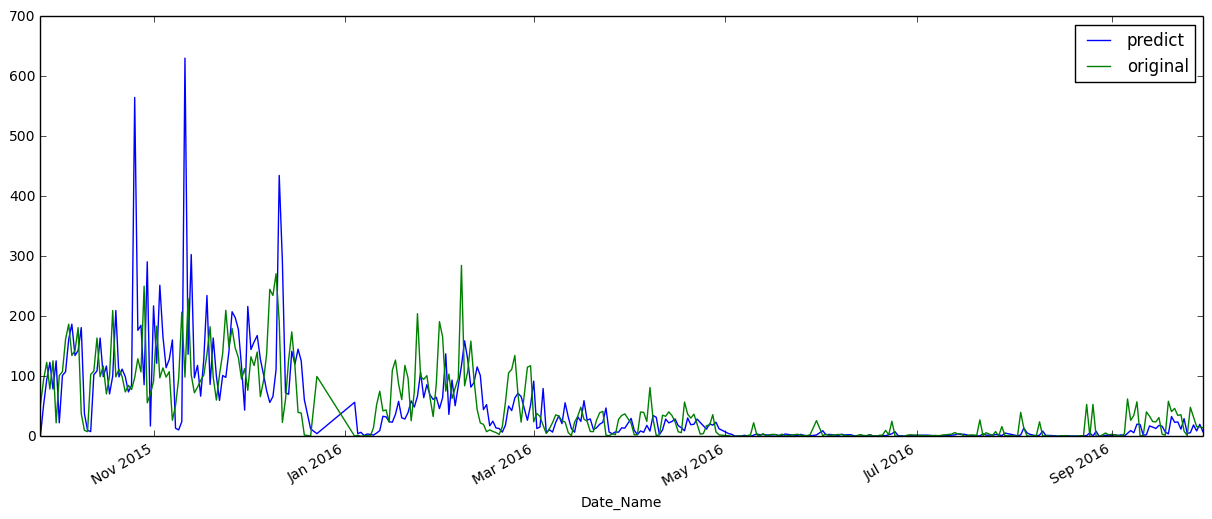

In [295]:
pred = np.exp(results_3.predict())
pred_90 = np.exp(results_3.predict(start=327, end=418, dynamic=True))
pred.plot(label='predict')
temp_A.plot(label='original')
plt.legend()

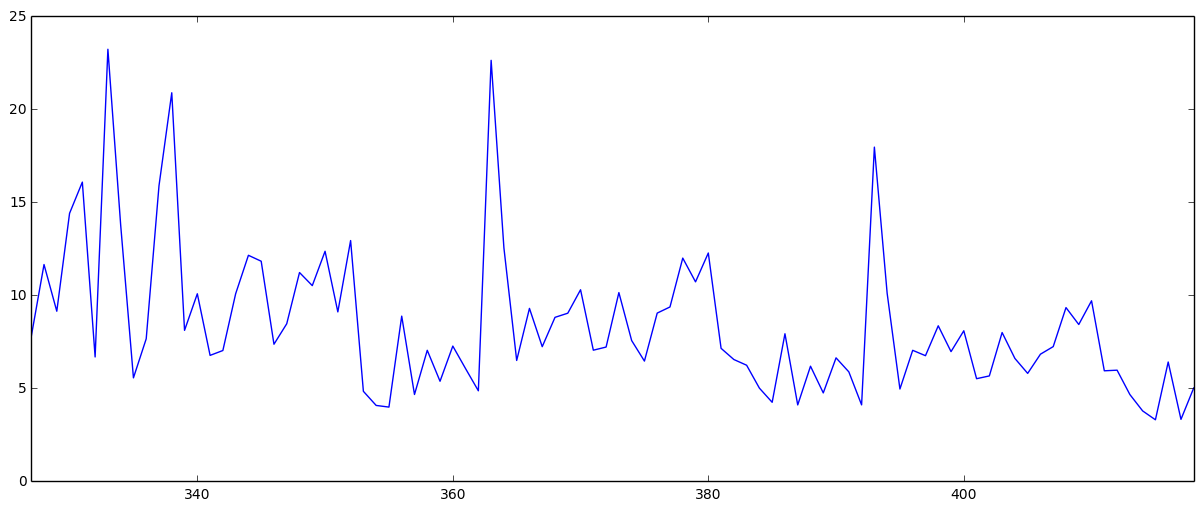

In [296]:
pred_90.plot()